# Analysis of time series

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal, stats
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
import tensorflow.random as tf_r

from keras import regularizers, initializers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

import seaborn 
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report

%run plot.py

# Exercise 3

In [ ]:
tf_r.set_seed(12345)
np.random.seed(12345)

EPOCHS=100
BATCH_SIZE = 250

### 2. Varying the amplitude A

N =  10000 L =  60 A  200


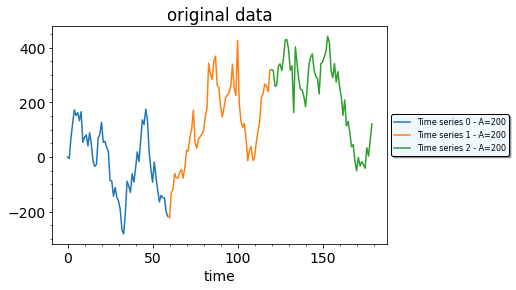

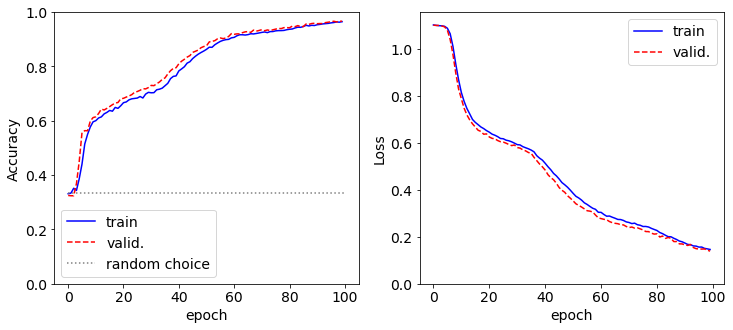

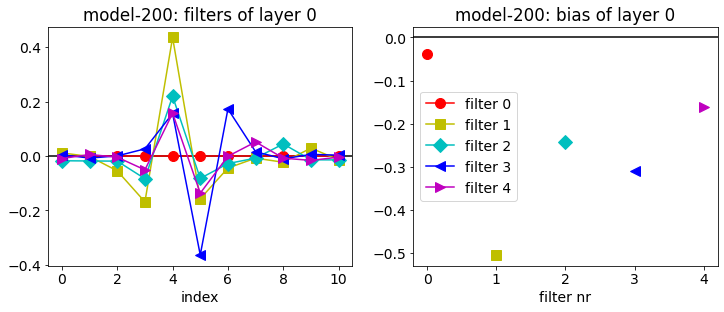

N =  10000 L =  60 A  400


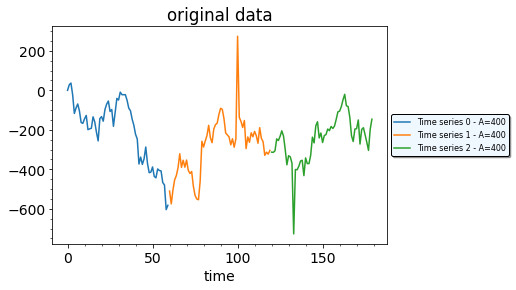

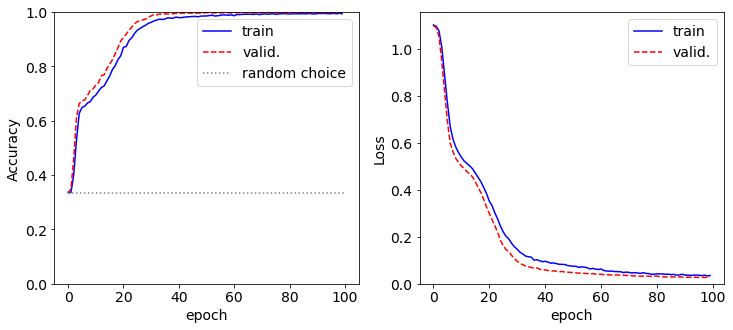

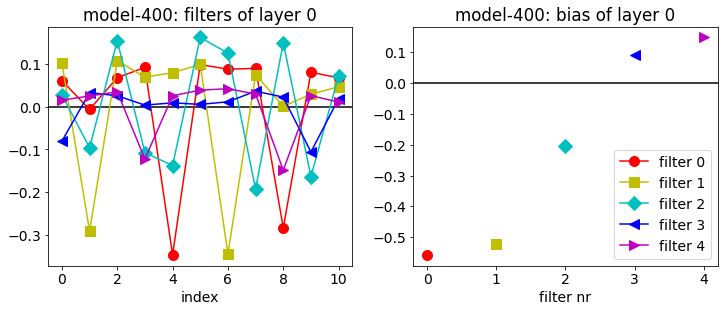

N =  10000 L =  60 A  500


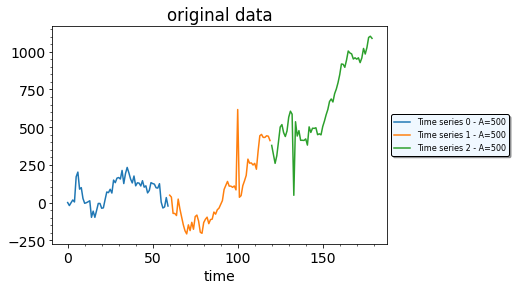

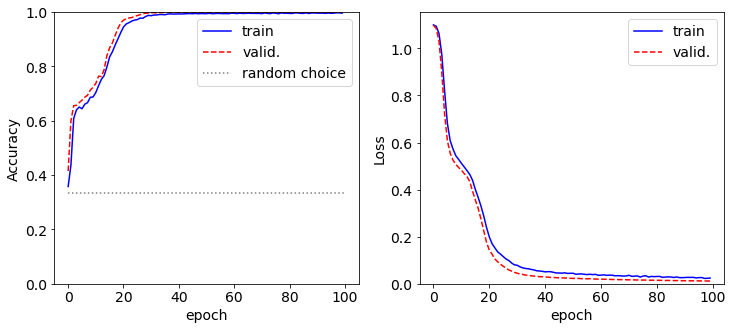

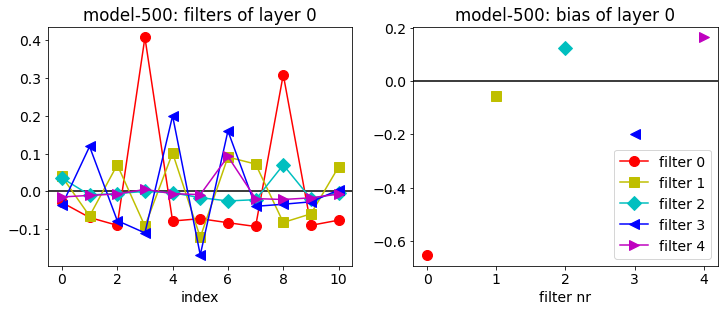

N =  10000 L =  60 A  600


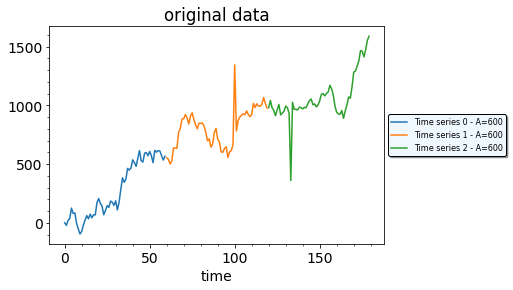

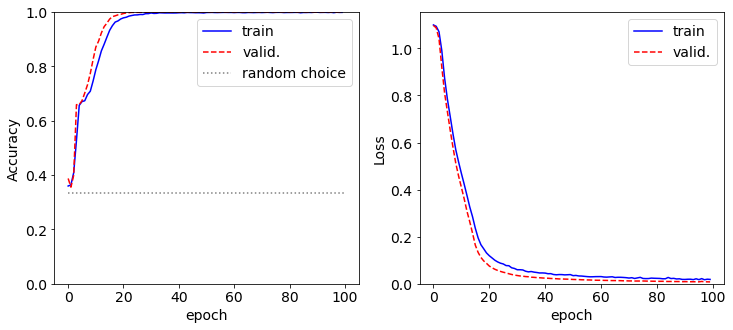

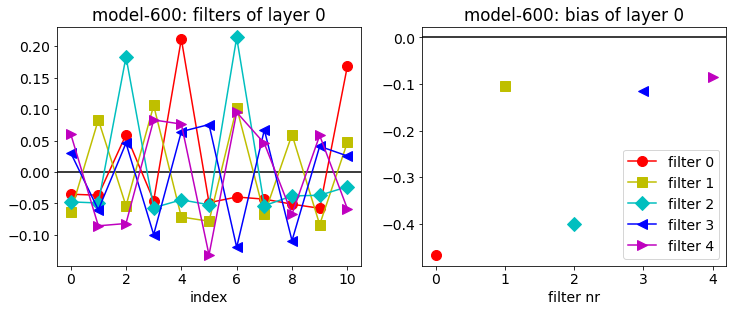

N =  10000 L =  60 A  700


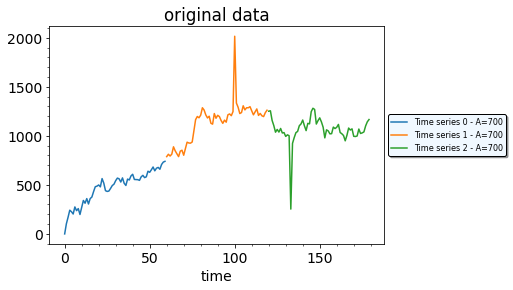

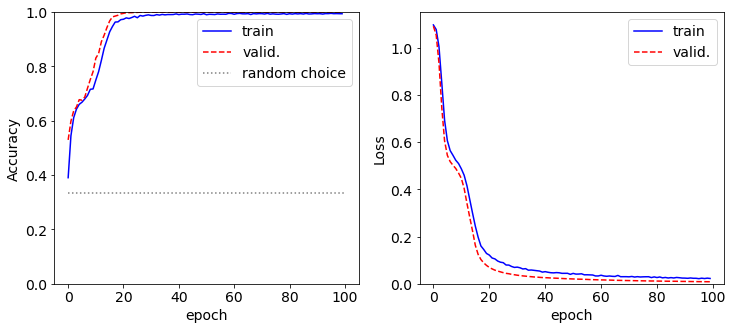

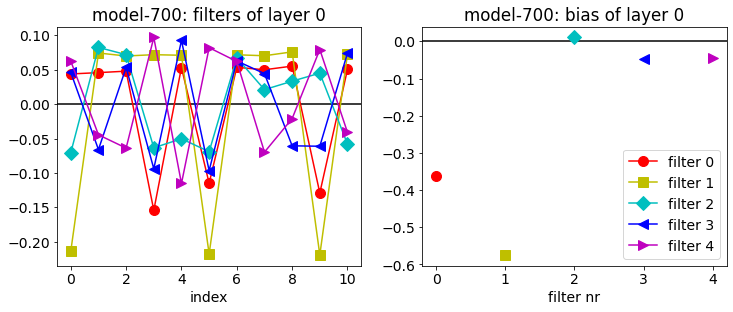

,Amplitude,Training loss,Test loss,Training Accuracy,Test Accuracy
0,200,0.118209,0.139035,0.971125,0.966
1,400,0.021907,0.027486,0.998,0.998
2,500,0.012078,0.011729,1.0,1.0
3,600,0.008181,0.008098,1.0,1.0
4,700,0.008816,0.008783,1.0,1.0


In [ ]:
amp_vals = np.array([200, 400, 500, 600, 700])
df= pd.DataFrame(columns=['Amplitude', 'Training loss', 'Test loss', 'Training Accuracy', 'Test Accuracy'])

for amplitude in amp_vals:
    fnamex = f'DATA/x_ts_L60_Z12_A{int(amplitude)}_DX50_bias5_N10000.dat'
    fnamey = f'DATA/y_ts_L60_Z12_A{int(amplitude)}_DX50_bias5_N10000.dat'

    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])

    print('N = ', N, 'L = ', L , 'A ', amplitude)
    Show_data(x,L,"Original data", nseries=3, show=True, A=amplitude)

    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1
    #print('data: ',N)

    # convert y to an (N x n_class) matrix

    # Directly pass to one hot encoding avoiding the for cycle
    y =tf.keras.utils.to_categorical(categ, n_class)
    # remove average value of each sample from its values
    xm = x.mean(axis=1)
    # subtract the mean avoiding the for cycle
    


    # preprocessing
    x_det = signal.detrend(x)
    x_det = x_det / np.std(x_det)
    
    #Show_data(x,L,"Rescaled data", nseries=3, show=True, A=amplitude)

    perc_train=0.8
    N_train = int(perc_train*N)
    x_train = x_det[:N_train]
    y_train = y[:N_train]
    x_val = x_det[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)
    #print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

    #x_train=x_train.astype("float32")
    #y_train=y_train.astype("float32")
    #x_val=x_val.astype("float32")
    #y_val=y_val.astype("float32")

    # Keras wants an additional dimension with a 1 at the end
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)
    input_shape = (L, 1)

    




    

    
    reg = regularizers.l2(0.02)# ridge with lambda
    #reg regularizerts.l1(0.1)
    ini = keras.initializers.RandomNormal(mean=0., stddev=.05, seed=None)

    NCONV = 1
    NF = 5 # number of filters

    model = Sequential()
    if NCONV == 1:
        #-----2----
        model.add(Conv1D(filters=NF, kernel_size=11, kernel_initializer=ini,
                        kernel_regularizer=reg, activation = 'relu', 
                        input_shape=input_shape))
        
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7,
                        activation='relu'))
        model.add(Flatten())# To be sent to a normal neural network layer
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))
        
    model.add(Dense(n_class, activation='softmax'))

    opt= tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt, metrics=['accuracy'])    
    BATCH_SIZE = 250
    EPOCHS = 100



    fit = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0, shuffle=True)
            
    eval_train = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
    eval_test = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)

    Show_history(fit)
    Show_weights(model,0,label="model"+str( - amplitude))

    

    df = pd.concat([df, pd.DataFrame(data=[[amplitude, eval_train[0], eval_test[0], eval_train[1], eval_test[1]]],
                                     columns=df.columns)
                    ], ignore_index=True)

display(df)

## 3. Grid Search for Regularization

In [ ]:
lambda_1 = 0.02
lambda_2 = 0.1
regl_2 = regularizers.l2(lambda_1)# ridge with lambda
reg_1 = regularizers.l1(lambda_2)
reg_1_2 = tf.keras.regularizers.l1_l2(l1=lambda_1, l2=lambda_2)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c8e8699-579b-4f24-9413-a98afebf04a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>